<a href="https://colab.research.google.com/github/joshua-meppiel/dl-workshop-2022/blob/main/Build_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPSCI 5390 - Semester Project - Task 2

The objective in this task is to design a convolutional neural network (not feed-forward neural network) and achieve the highest possible accuracy on the validation and test datasets.



This task uses the same model architecture as the Subtask 1, but without supplying the ground truth (output labels) as part of the model input. 


Note: I have used dataset generators, but the randomness seed value is always set to `123` for reproducability.

# Imports and copy data

Import the various libraries used throughout the notebook and set the training and test data directories.

In [13]:
import numpy as np, pathlib, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

data_dir = pathlib.Path('/home/josh/data/asl/train')
test_data_dir = pathlib.Path('/home/josh/data/asl/test/')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count)

87000
29


# Check versions and devices

Output the TensorFlow and Numpy versions along with the number of CPU's and number of GPU's available.  I do this as I am running the notebook inside of Ubuntu on WSL, not in the cloud.  I've had issues with certain versions of TensoFlow and Numpy, particularly around data augmentation.

In [14]:
print(f"TensorFlow version: ", tf.__version__)
print(f"Numpy version: ", np.__version__)

print(f"Available CPU(s): ", len(tf.config.list_physical_devices('CPU')))
print(f"Available GPU(s): ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.12.0
Numpy version:  1.23.5
Available CPU(s):  1
Available GPU(s):  1


# Load data into traning and validation sets

Create the datasets using the Keras `image_dataset_from_directory` utility.  This utility is useful when the dataset is too large to fit into the GPU's memory.  It will load one batch at a time into memory and has automatic caching mechanisms to improve performance.  At the end we print the class names and the number of classes.

In this Task 1, we do not supply the ground truths as an input; however, we also do not split the dataset into a separate training and validation(nor test) datasets.  All data is supplied to the network as both training and validation.

In [15]:
batch_size = 48
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


# Test display images

This selects 9 images from the dataset and displays them along with their labels.  This is for verification purposes only to ensure that the dataset is loading images as expected.



2023-04-10 21:20:38.520309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [69600]
	 [[{{node Placeholder/_0}}]]
2023-04-10 21:20:38.520514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [69600]
	 [[{{node Placeholder/_0}}]]


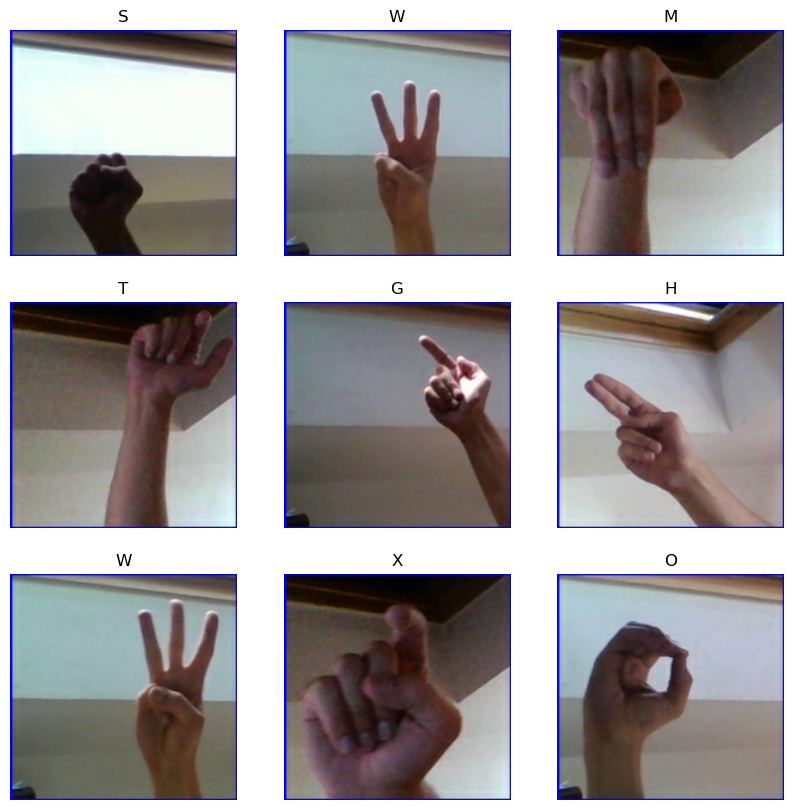

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Create the model

This creates the model.  This is the same architecture as Subtask 1.

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(width_factor=0.1,height_factor=0.1)
  ]
)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Create Callbacks

Here I create a custom callback function.  This function monitors the training accuracy, when it reaches 100% it stops the training early.

In [18]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0)

# Compile the Model

Here we set the optimizer and compile the model.  We then print the sumamry of the model.

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 16)      4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0   

# Display the model structure

Display a graphical representation of the model structure.

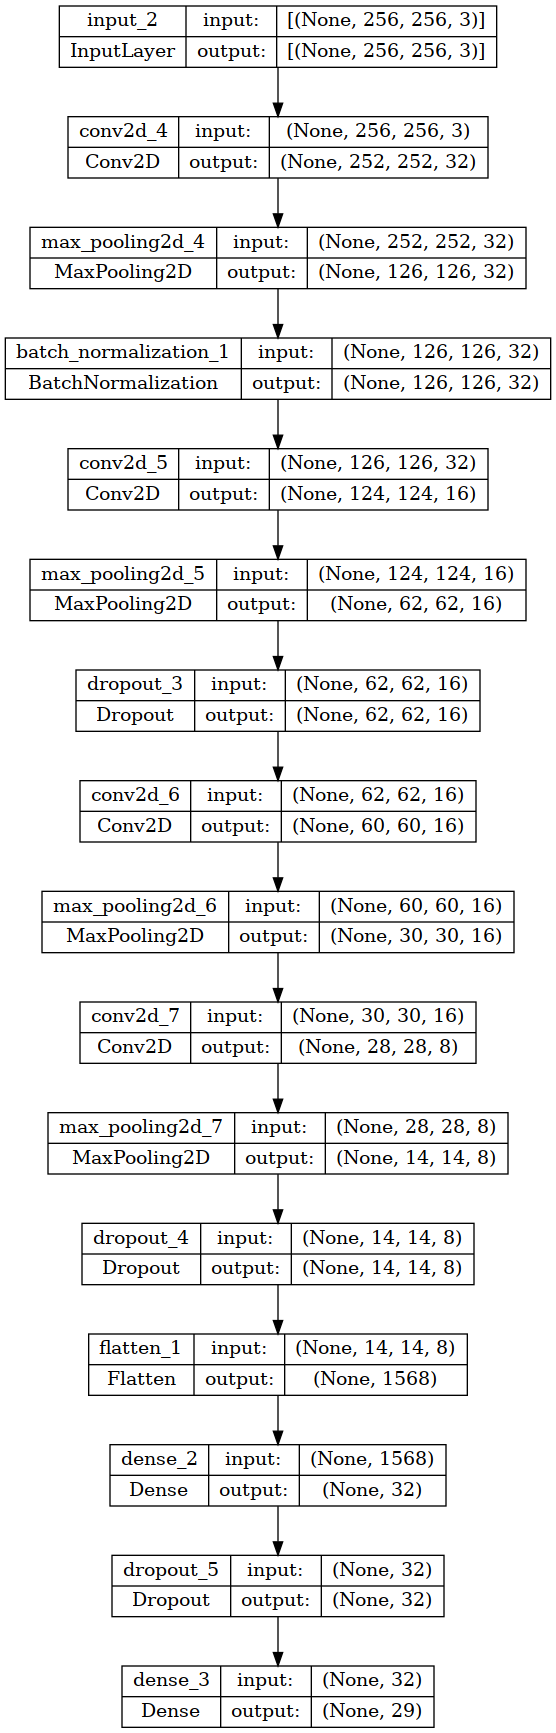

In [20]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Train the model

Here we train the model.  Note that here we are supplying the training data for both the training and validation sets to the `fit()` function.

In [21]:
history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[callback])

Epoch 1/10


2023-04-10 21:20:39.617600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]
2023-04-10 21:20:39.617850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [69600]
	 [[{{node Placeholder/_4}}]]
2023-04-10 21:20:40.111063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1449/1450 [============================>.] - ETA: 0s - loss: 2.4462 - accuracy: 0.2529

2023-04-10 21:22:07.725638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [17400]
	 [[{{node Placeholder/_4}}]]
2023-04-10 21:22:07.725850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [17400]
	 [[{{node Placeholder/_4}}]]


1450/1450 [==============================] - 96s 65ms/step - loss: 2.4454 - accuracy: 0.2531 - val_loss: 1.2005 - val_accuracy: 0.6255
Epoch 2/10
1450/1450 [==============================] - 92s 63ms/step - loss: 1.2294 - accuracy: 0.5700 - val_loss: 0.7933 - val_accuracy: 0.7481
Epoch 3/10
1450/1450 [==============================] - 87s 60ms/step - loss: 0.9109 - accuracy: 0.6753 - val_loss: 0.7404 - val_accuracy: 0.7678
Epoch 4/10
1450/1450 [==============================] - 92s 64ms/step - loss: 0.7599 - accuracy: 0.7293 - val_loss: 0.5281 - val_accuracy: 0.8463
Epoch 5/10
1450/1450 [==============================] - 91s 63ms/step - loss: 0.6541 - accuracy: 0.7690 - val_loss: 0.3874 - val_accuracy: 0.8869
Epoch 6/10
1450/1450 [==============================] - 90s 62ms/step - loss: 0.5812 - accuracy: 0.7928 - val_loss: 0.2989 - val_accuracy: 0.9055
Epoch 7/10
1450/1450 [==============================] - 90s 62ms/step - loss: 0.5388 - accuracy: 0.8100 - val_loss: 0.2452 - val_accura

# Investigate Learning 

Plot the training and loss statistics for the training of the model.

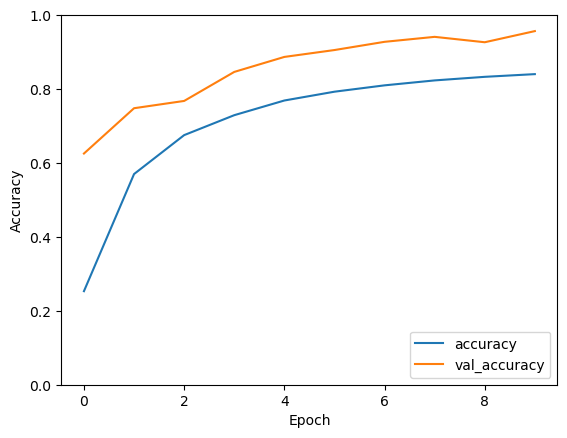

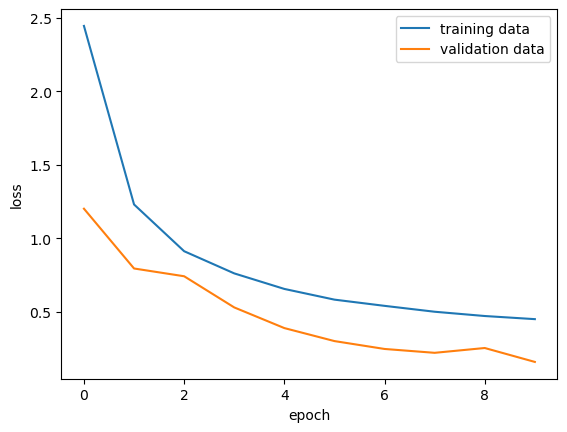

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss']) # replace with accuracy/MAE
plt.plot(history.history['val_loss']) # replace with val_accuracy, etc.
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='upper right')

plt.show()

# Validation Data Set

Evaluate the model.

In [23]:
valid_loss, valid_acc = model.evaluate(valid_ds, verbose=2)

363/363 - 8s - loss: 0.1569 - accuracy: 0.9568 - 8s/epoch - 21ms/step


# Make Predictions and Evaluate the Model on Test Data

Create the test dataset.  Evaluate the model on this test dataset.  Note that on this Task 1 the accuracy is very low when evaluatiing the model using the test dataset.

Plot all 29 images along with their ground truth labels(left side of colon) and predicted labels(right side of colon).

Found 29 files belonging to 29 classes.
1/1 - 0s - loss: 0.1889 - accuracy: 0.8966 - 29ms/epoch - 29ms/step


2023-04-10 21:35:57.543413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]
2023-04-10 21:35:57.543601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{node Placeholder/_4}}]]
2023-04-10 21:35:57.575888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29]
	 [[{{n

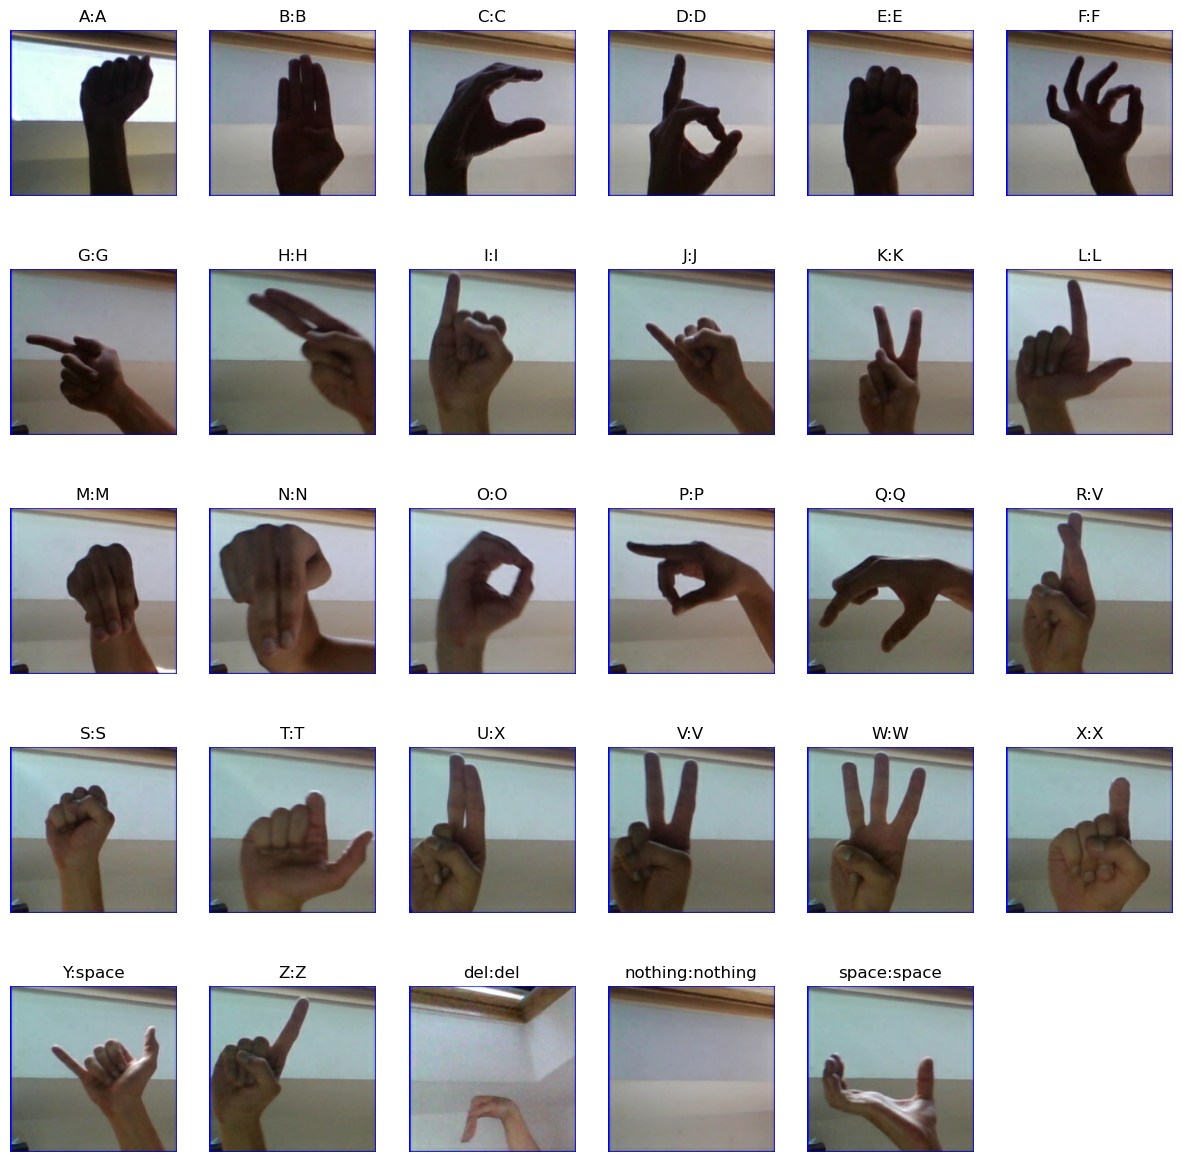

In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  subset=None,
  seed=None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
test_class_names = test_ds.class_names
test_ds_instance = test_ds.take(1)

plt.figure(figsize=(15, 15))
for images, labels in test_ds_instance:
  for i in range(29):
    x = np.expand_dims(images[i], axis=0)
    p = model.predict(x, verbose=0)    
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + ":" + class_names[p.argmax()])
    plt.axis("off")